#### <u>MP3 Solution - Digital twin of pump drive with VFD</u>

The solution covers all these points that were in the instructions:

- Pump + system physics: solves for the operating point by equating pump and system curves (see solve_operating_point)

- Affinity scaling: pump head intercept scales with ($N_1/N_2)^2$ ; power via $N^3$ (see solve_operating_point, estimate_power_kw)

- PI controller on head producing a speed command. (see controller_pi)

- VFD behavior via ramp rate + min/max rpm clamping.(see vfd_apply)

- Sensor model with bias + noise. - (see sensor_head uses 0.95×ideal ± small noise)

- Energy & volume accounting + specific energy. (see accumulate, specific_energy)

- Baseline simulation and time-series plots (head tracking; speed vs command; flow; power & SE). (see run_simulation, plot_basic_timeseries)

- Setpoint sweep summary table (steady-state energy vs setpoint). (see sweep_energy_vs_setpoint)

- Running baseline and operational simulations


In [9]:
import math, random
from dataclasses import dataclass
from typing import Iterable, Optional, Tuple, List

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

# VFD Pump Twin — system_curve only

# Configuration

RANDOM_SEED = 0
DT = 0.1                      # s
SIM_TIME_S = 60.0             # s
HEAD_SP = 25.0                # m (head setpoint)

# Pump @ design speed
H0 = 41.0                     # m  (shutoff head at design speed)
K_PUMP = 0.010                # (m)/(m3/h)^2
N_DESIGN = 1800.0             # rpm

# System curve
H_STATIC = 6.0                # m
K_SYS = 0.012                 # (m)/(m3/h)^2


# Super-tiny head ingestor (dt=0.1 s) for checking working of twin

def ingest_head_stream(heads: Iterable[float], dt: float = DT):
    """Yield (t, H_meas) samples at fixed dt from a simple list/iterable."""
    t = 0.0
    for h in heads:
        yield t, float(h)
        t += dt


# Parameters & twin

@dataclass
class TwinParams:
    min_rpm: float = 800.0
    max_rpm: float = 1800.0
    Kp: float = 8.0
    Ki: float = 1.0
    dt: float = DT
    vfd_ramp_rate_rpm_s: float = 2000.0   # rpm/s
    rated_power_kw: float = 15.0          # at design speed

class PumpTwin:
    """Minimal twin: system_curve physics, PI on head, VFD ramp, energy & volume."""
    def __init__(self, p: TwinParams):
        self.p = p
        self.rpm = p.min_rpm
        self.I = 0.0
        self.energy_kwh = 0.0
        self.volume_m3 = 0.0

    # ---- Physics ----
    def solve_operating_point(self, rpm: float) -> Tuple[float, float]:
        """Return (Q [m3/h], H_ideal [m]) from H_pump(Q,N)=H_static + K_sys Q^2."""
        ratio2 = (rpm / N_DESIGN) ** 2
        left = H0 * ratio2 - H_STATIC
        denom = K_PUMP + K_SYS
        if left <= 0.0 or denom <= 0.0:
            Q = 0.0
        else:
            Q = math.sqrt(left / denom)
        H = H_STATIC + K_SYS * Q * Q
        return Q, H

    def estimate_power_kw(self, rpm: float) -> float:
        """Cubic law relative to design speed."""
        r = rpm / N_DESIGN
        return self.p.rated_power_kw * (r ** 3)

    # ---- Controller ----
    def controller_pi(self, H_sp: float, H_meas: float) -> float:
        e = H_sp - H_meas
        self.I += e * self.p.dt
        N_cmd = self.rpm + self.p.Kp * e + self.p.Ki * self.I
        return max(self.p.min_rpm, min(self.p.max_rpm, N_cmd))

    # ---- VFD ramp ----
    def vfd_apply(self, N_cmd: float) -> float:
        max_step = self.p.vfd_ramp_rate_rpm_s * self.p.dt
        delta = N_cmd - self.rpm
        if abs(delta) > max_step:
            delta = math.copysign(max_step, delta)
        self.rpm = max(self.p.min_rpm, min(self.p.max_rpm, self.rpm + delta))
        return self.rpm

    # ---- Energy / volume ----
    def accumulate(self, P_kw: float, Q_m3_h: float):
        self.energy_kwh += P_kw * (self.p.dt / 3600.0)
        self.volume_m3 += max(0.0, Q_m3_h) * (self.p.dt / 3600.0)

    def specific_energy(self) -> Optional[float]:
        if self.volume_m3 <= 1e-12:
            return None
        return self.energy_kwh / self.volume_m3


# Simple sensor model

def sensor_head(H_ideal: float) -> float:
    """Simulated measured head = 0.95 * ideal + small noise."""
    return max(0.0, 0.95 * H_ideal + random.uniform(-0.5, 0.5))


# Simulation (system_curve only)

def run_simulation(
    H_sp: float = HEAD_SP,
    sim_time_s: float = SIM_TIME_S,
    params: TwinParams = TwinParams(),
    external_head_stream: Optional[Iterable[Tuple[float, float]]] = None
) -> Tuple[List[dict], PumpTwin]:

    random.seed(RANDOM_SEED)
    twin = PumpTwin(params)
    steps = int(sim_time_s / params.dt)

    head_iter = iter(external_head_stream) if external_head_stream is not None else None

    log: List[dict] = []
    for k in range(steps):
        t = k * params.dt

        # Physics: system-curve operating point at current rpm
        Q, H_ideal = twin.solve_operating_point(twin.rpm)

        # Measurement: external stream (if provided) else simulated sensor
        if head_iter is not None:
            try:
                t_in, H_meas = next(head_iter)
            except StopIteration:
                H_meas = sensor_head(H_ideal)
        else:
            H_meas = sensor_head(H_ideal)

        # Control → speed command → VFD ramp
        N_cmd = twin.controller_pi(H_sp, H_meas)
        rpm = twin.vfd_apply(N_cmd)

        # Power & accounting
        P_kw = twin.estimate_power_kw(rpm)
        twin.accumulate(P_kw, Q)

        log.append(dict(
            t=t, H_sp=H_sp, H_meas=H_meas, H_ideal=H_ideal,
            flow_m3_h=Q, rpm=rpm, N_cmd=N_cmd,
            P_kw=P_kw, E_kWh=twin.energy_kwh, V_m3=twin.volume_m3
        ))

    return log, twin


# Sweep (steady state)

def sweep_energy_vs_setpoint(setpoints, settle_s=40.0) -> pd.DataFrame:
    rows = []
    for sp in setpoints:
        log, twin = run_simulation(H_sp=sp, sim_time_s=settle_s, params=TwinParams())
        last = log[-1]
        rows.append(dict(
            setpoint_m=sp,
            rpm=last["rpm"],
            flow_m3_h=last["flow_m3_h"],
            power_kw=last["P_kw"],
            specific_kwh_per_m3=twin.specific_energy()
        ))
    return pd.DataFrame(rows)


# Minimal plots

def plot_basic_timeseries(df: pd.DataFrame, title: str = ""):
    fig, axes = plt.subplots(4, 1, figsize=(9, 10), sharex=True)
    ax = axes[0]
    ax.plot(df.t, df.H_sp, label="Head SP [m]")
    ax.plot(df.t, df.H_meas, label="Head meas [m]")
    ax.set_ylabel("Head [m]"); ax.legend(); ax.grid(True)

    ax = axes[1]
    ax.plot(df.t, df.rpm, label="Speed [rpm]")
    ax.plot(df.t, df.N_cmd, "--", label="Speed cmd [rpm]")
    ax.set_ylabel("rpm"); ax.legend(); ax.grid(True)

    ax = axes[2]
    ax.plot(df.t, df.flow_m3_h, label="Flow [m³/h]")
    ax.set_ylabel("Flow [m³/h]"); ax.legend(); ax.grid(True)

    ax = axes[3]
    ax.plot(df.t, df.P_kw, label="Power [kW]")
    ax2 = ax.twinx()
    se = df.E_kWh / df.V_m3.replace(0, float("nan"))
    ax2.plot(df.t, se, "--", label="SE [kWh/m³]")
    ax.set_ylabel("kW"); ax2.set_ylabel("kWh/m³"); ax.set_xlabel("Time [s]")
    ax.grid(True)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="best")

    fig.suptitle(title or "Minimal Pump Twin — system_curve", y=0.98)
    plt.tight_layout(); plt.show()


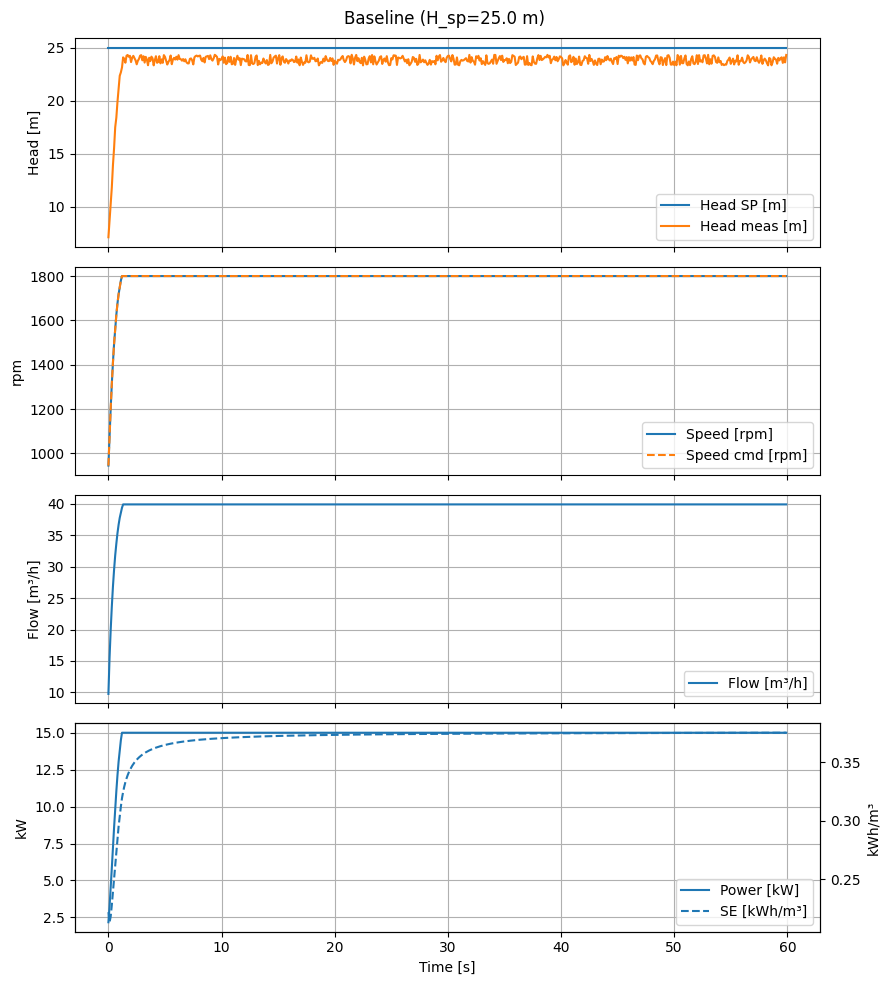


--- Final state ---
t=59.9s, rpm=1800.0
H_meas=24.32 m (SP=25.00 m)
Q=39.89 m³/h, P=15.00 kW
E=0.248 kWh, V=0.661 m³, SE=0.375 kWh/m³

--- Sweep: SE vs Head setpoint ---
 setpoint_m         rpm  flow_m3_h  power_kw  specific_kwh_per_m3
         18 1525.481307  32.699625  9.130497             0.283822
         20 1622.364923  35.283403 10.982960             0.316206
         22 1713.790041  37.690641 12.946327             0.348732
         25 1800.000000  39.886202 15.000000             0.374712
         28 1800.000000  39.886202 15.000000             0.375225


In [ ]:
# Demonstrate Baseline running of twin

log, twin = run_simulation(H_sp=HEAD_SP, sim_time_s=SIM_TIME_S, params=TwinParams())
df = pd.DataFrame(log)
plot_basic_timeseries(df, f"Baseline (H_sp={HEAD_SP} m)")

print("\n--- Final state ---")
last = df.iloc[-1]
print(f"t={last.t:.1f}s, rpm={last.rpm:.1f}")
print(f"H_meas={last.H_meas:.2f} m (SP={last.H_sp:.2f} m)")
print(f"Q={last.flow_m3_h:.2f} m³/h, P={last.P_kw:.2f} kW")
print(f"E={last.E_kWh:.3f} kWh, V={last.V_m3:.3f} m³, SE={twin.specific_energy() or float('nan'):.3f} kWh/m³")

# Steady-state sweep
print("\n--- Sweep: SE vs Head setpoint ---")
sweep_df = sweep_energy_vs_setpoint([18, 20, 22, 25, 28], settle_s=40.0)
print(sweep_df.to_string(index=False))

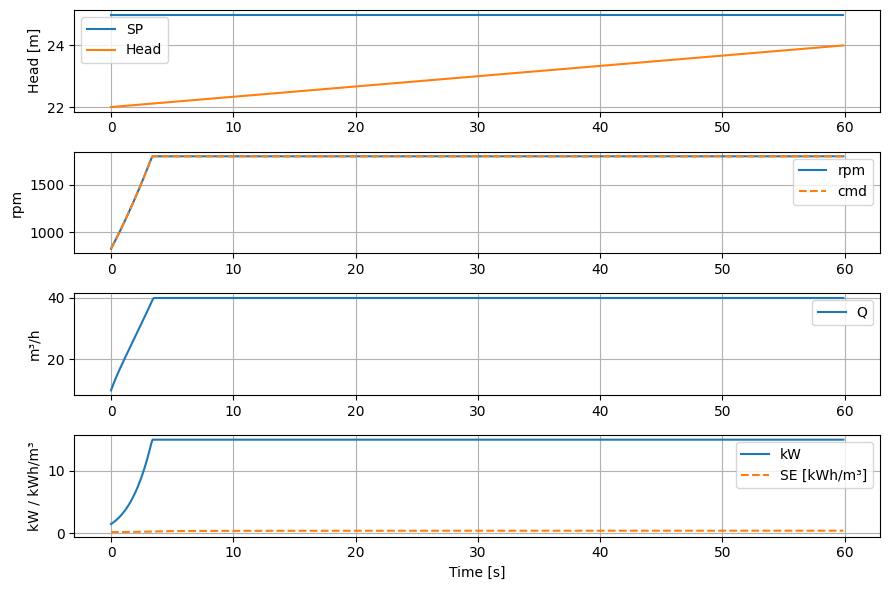

In [ ]:
# Collecting 60 s of head data at 0.1s using the tiny data ingestor

heads = np.linspace(22.0, 24.0, int(60/DT)).tolist()  # gentle ramp for 60 s
duration_s = len(heads) * DT
head_stream = ingest_head_stream(heads, dt=DT)

log, twin = run_simulation(
    H_sp=25.0,
    sim_time_s=duration_s,        # or longer to let it fall back to simulated sensor after your stream ends
    params=TwinParams(),
    external_head_stream=head_stream
)


df = pd.DataFrame(log) # Convert to a dataframe

plt.figure(figsize=(9,6))
plt.subplot(4,1,1); plt.plot(df.t, df.H_sp, label="SP"); plt.plot(df.t, df.H_meas, label="Head"); plt.ylabel("Head [m]"); plt.legend(); plt.grid(True)
plt.subplot(4,1,2); plt.plot(df.t, df.rpm, label="rpm"); plt.plot(df.t, df.N_cmd, "--", label="cmd"); plt.ylabel("rpm"); plt.legend(); plt.grid(True)
plt.subplot(4,1,3); plt.plot(df.t, df.flow_m3_h, label="Q"); plt.ylabel("m³/h"); plt.legend(); plt.grid(True)
plt.subplot(4,1,4); plt.plot(df.t, df.P_kw, label="kW"); 
se = df.E_kWh / df.V_m3.replace(0, float("nan"))
plt.plot(df.t, se, "--", label="SE [kWh/m³]"); plt.ylabel("kW / kWh/m³"); plt.xlabel("Time [s]"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()


That is exactly what the setup should do with a **60-s rising head stream**:

* The injected **head** goes from ~22→24 m, so the error $(H_{sp}-H_{meas})$ stays positive → the PI keeps **increasing speed** until it hits the **max 1800 rpm** (limited by the VFD ramp in the first few seconds).
* Once at 1800 rpm, the **operating point** on the system curve gives **Q ≈ 40 m³/h** and **P ≈ 15 kW**, both flat after the ramp.
* **SE (kWh/m³)** settles near ~0.376 (≈ 15 kW / 39.9 m³/h), as expected.



In [13]:
# Simulation function to run up to a head of 25 and then drop to 15 after 1s

def run_simulation_scheduled(
    sp_high=25.0,          # initial head setpoint [m]
    sp_low_factor=0.60,    # drop to 60% of high SP
    t_change_s=1.0,        # after 10 steps at dt=0.1 s
    sim_time_s=60.0,
    params=TwinParams(),
    external_head_stream=None
):
    """Same twin, but with a step in head setpoint at t_change_s."""
    random.seed(RANDOM_SEED)
    twin = PumpTwin(params)
    steps = int(sim_time_s / params.dt)
    head_iter = iter(external_head_stream) if external_head_stream is not None else None
    sp_low = sp_high * sp_low_factor

    log = []
    for k in range(steps):
      t = k * params.dt
      H_sp = sp_high if t < t_change_s else sp_low

      # physics
      Q, H_ideal = twin.solve_operating_point(twin.rpm)

      # measurement
      if head_iter is not None:
          try:
              _, H_meas = next(head_iter)
          except StopIteration:
              H_meas = sensor_head(H_ideal)
      else:
          H_meas = sensor_head(H_ideal)

      # control + VFD
      N_cmd = twin.controller_pi(H_sp, H_meas)
      rpm   = twin.vfd_apply(N_cmd)

      # power/energy
      P_kw = twin.estimate_power_kw(rpm)
      twin.accumulate(P_kw, Q)

      log.append(dict(t=t, H_sp=H_sp, H_meas=H_meas, H_ideal=H_ideal,
                      flow_m3_h=Q, rpm=rpm, N_cmd=N_cmd,
                      P_kw=P_kw, E_kWh=twin.energy_kwh, V_m3=twin.volume_m3))
    return log, twin


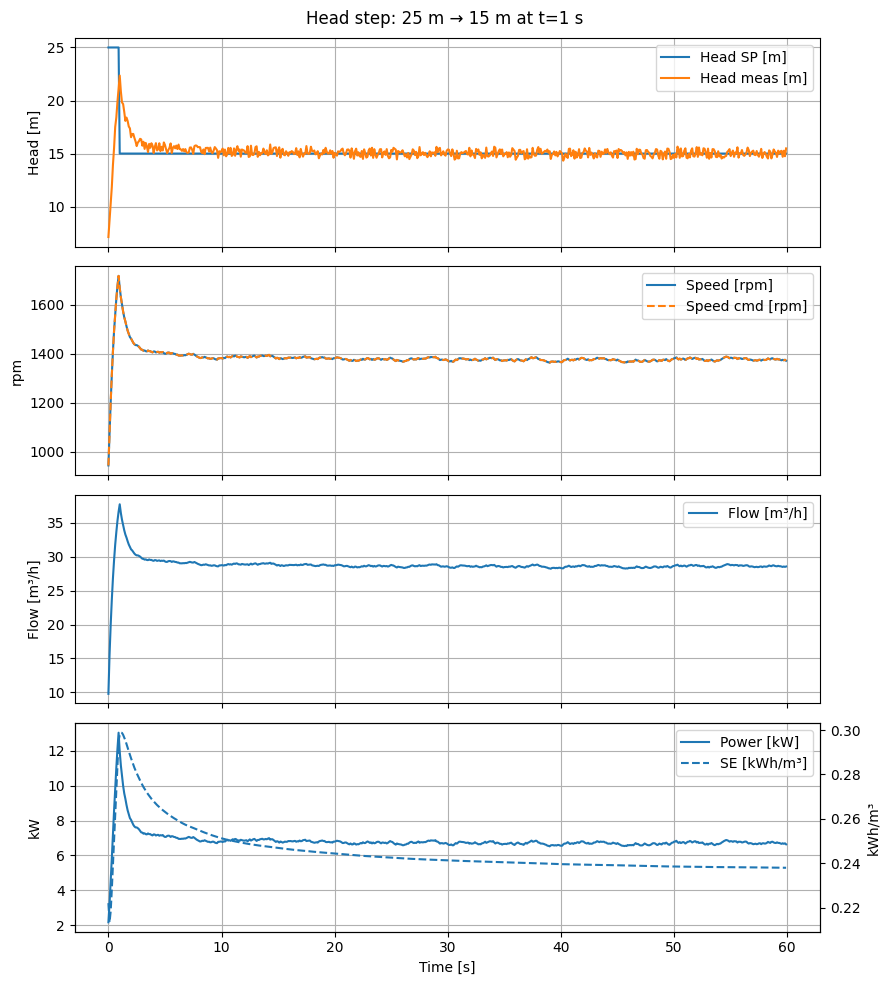

In [14]:
# Run the simulation
# Step at t = 1.0 s (10 steps @ dt=0.1), from 25 m → 15 m (60%)
log, twin = run_simulation_scheduled(
    sp_high=25.0, sp_low_factor=0.60, t_change_s=1.0,
    sim_time_s=60.0, params=TwinParams()
)

df = pd.DataFrame(log)
plot_basic_timeseries(df, title="Head step: 25 m → 15 m at t=1 s")


What the plot shows matches the physics and the controller:

* **Before 1 s:** the loop chases the 25 m setpoint → speed rises, then at the step you drop to **15 m**.
* **After the step:** speed settles around ~**1.33–1.40 krpm** (ballpark we predicted), flow drops to ~**30 m³/h**, and **power falls** to about **6–7 kW** (≈ cubic with speed).
* **SE (kWh/m³)** decreases accordingly—nice visual proof of energy savings with reduced head.

Notes:

* The sensor model is biased: $(H_\text{meas}=0.95,H_\text{ideal})  + noise$, so measured head sits a bit **below** setpoint even when the loop is “on target.” If you want it to land right on 15 m, either (a) raise the setpoint to ~15.8 m, or (b) set the sensor to `1.0*ideal` temporarily.
* If you want less overshoot/noise, drop (K_p) a touch (e.g., 6–7) or add a small moving average to **displayed** traces only.

What to expect (sanity math)

With the system and pump numbers, the steady-state head at the operating point scales roughly with 
$(N/N1)^2$ through the pump and system intersection.

- To hold 25 m, you need ~1800 rpm (as you’ve seen)

- Dropping to 15 m (60% of 25 m) gives an rpm of about:<br>
$N = 1800 ((15-6)/(41-6))^0.5  = 1330rpm$

- Power follows the cubic law, so it falls to roughly:<br>
$P = 15 KW (1330/1800)^3 = 6 KW$


So you should see: rpm ramp to ~1800 rpm before the step, then decay toward ~1330 rpm; flow and power drop accordingly; specific energy decreases in the low-setpoint phase.


##### <u>Additional plots to show operating point on pump curves</u>

This demionstrates how the CF pump traverses the different curves to reach its operating point.

Plots the pump curve @ RPM, the system curve, and marks the operating point.

In [15]:
def plot_QH_operating_point_with_globals(
    rpm,
    H0=H0, K_PUMP=K_PUMP, N_DESIGN=N_DESIGN,
    H_STATIC=H_STATIC, K_SYS=K_SYS,
    q_max=None, ax=None, title=None
):
    """
    Uses your global constants:
      H0, K_PUMP, N_DESIGN, H_STATIC, K_SYS
    Plots pump & system curves at the given rpm and marks the operating point.
    Returns (Q_op, H_op).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Affinity scaling of head intercept at this RPM
    speed_ratio = float(rpm) / float(N_DESIGN)
    H0_rpm = H0 * (speed_ratio ** 2)

    # Choose x-range to nicely include the intersection
    if q_max is None:
        denom = (K_PUMP + K_SYS)
        if denom > 0 and (H0_rpm - H_STATIC) > 0:
            q_int = np.sqrt((H0_rpm - H_STATIC) / denom)
            q_max = 1.3 * q_int if q_int > 0 else 10.0
        else:
            q_max = 10.0

    Q = np.linspace(0.0, q_max, 400)
    H_pump = H0_rpm - K_PUMP * (Q ** 2)
    H_sys  = H_STATIC + K_SYS * (Q ** 2)

    # Operating point (analytic or sampled). Sampled is robust:
    idx = np.argmin(np.abs(H_pump - H_sys))
    Q_op = float(Q[idx])
    H_op = float(H_pump[idx])

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    if title is None:
        title = f"Q–H Operating Point @ {rpm:.0f} rpm"

    ax.plot(Q, H_pump, label=f"Pump curve @ {rpm:.0f} rpm")
    ax.plot(Q, H_sys,  label="System curve")
    ax.plot([Q_op], [H_op], "o", markersize=7, label=f"Operating point ≈ ({Q_op:.2f}, {H_op:.2f} m)")

    ax.set_xlabel("Flow Q (m³/h)")
    ax.set_ylabel("Head H (m)")
    ax.set_title(title)
    ax.grid(True, alpha=0.4)
    ax.legend()
    return Q_op, H_op


Plot the operating point at any RPM (e.g., last steady value)

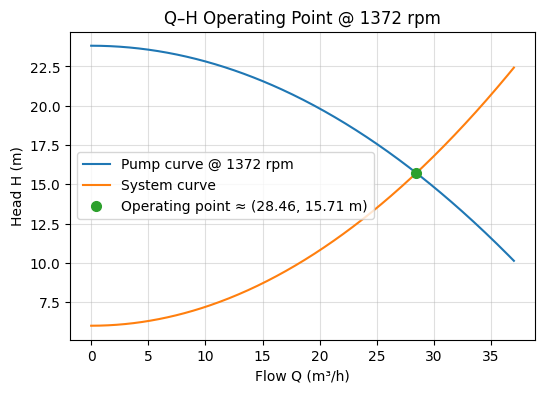

In [16]:
Qop, Hop = plot_QH_operating_point_with_globals(rpm=df["rpm"].iloc[-1])

Show how the step moved the operating point (before vs after):

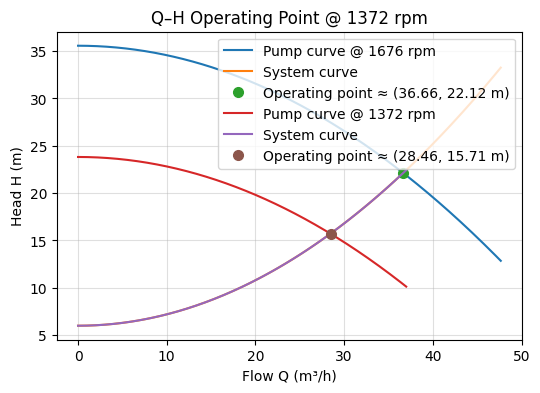

In [17]:
ax = None
rpm1 = df.loc[df["t"] < 0.9, "rpm"].iloc[-1]   # before step (adjust time as needed)
rpm2 = df.loc[df["t"] > 2.0, "rpm"].iloc[-1]   # after step  (adjust time as needed)
Q1, H1 = plot_QH_operating_point_with_globals(rpm1, ax=ax, title="Q–H Operating Points (Step Test)")
Q2, H2 = plot_QH_operating_point_with_globals(rpm2, ax=plt.gca())

